## 毒品資料為基礎建立隨機森林模型
1. 不處理資料不平衡分佈
2. 超參數調教
3. 計算效能指標
4. ROC_AUC Curve
5. factor importance
6. confusion matrix

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [4]:
plt.rcParams['font.sans-serif']=['Microsoft Jhenghei']
plt.rcParams['axes.unicode_minus']=False

### 資料讀取

In [5]:
df = pd.read_csv("../data/traindrug.csv", encoding="utf8")

In [6]:
df.shape

(65402, 16)

### 建立訓練集與測試集(X, y)

In [7]:
#X = df.drop(labels=['再犯註記'], axis=1).values
#y = df['再犯註記'].values
X = df.drop(labels=['再犯註記'], axis=1)
y = df['再犯註記']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X_train, y_train) #X, y

### 超參數調教

In [10]:
# Import Random Forest model
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(random_state = 42)

In [11]:
rf.get_params() #get default params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### design of param grid

In [11]:
n_estimators = np.arange(100, 2000, step=200)
max_features = ["auto", "sqrt", "log2"]
max_depth = np.arange(1, 100, step=10)
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 3, 4, 5]
bootstrap = [True, False]

In [12]:
param_grid={
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [13]:
param_grid

{'n_estimators': array([ 100,  300,  500,  700,  900, 1100, 1300, 1500, 1700, 1900]),
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
 'min_samples_split': array([2, 4, 6, 8]),
 'min_samples_leaf': [1, 2, 3, 4, 5],
 'bootstrap': [True, False]}

### random search for hyperparameters

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
forest = RandomForestClassifier()
rand_cv = RandomizedSearchCV(forest, param_grid, n_iter=100, cv=5, scoring="roc_auc", n_jobs=-1)

在機器學習模型中，需要人工選擇的參數稱爲超參數。

In [16]:
#rfmodel=rand_cv.fit(X_train, y_train)
rfsmote = rand_cv.fit(X_over, y_over)

In [17]:
rand_cv.best_score_

0.9239797966288705

In [18]:
print(rand_cv.best_params_) # obtain params by random search

{'n_estimators': 1500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 31, 'bootstrap': True}


In [25]:
new_params = {
    "n_estimators": [1400, 1450, 1500, 1550, 1600],
    "max_features": ['sqrt'],
    "max_depth": [28,30,32],
    "min_samples_split":[2],
    "min_samples_leaf": [1],
    "bootstrap": ["True"],
}

### fine turning hyperparameters by grid search

In [26]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(forest, new_params, cv=3,scoring="roc_auc", n_jobs=-1)

In [27]:
import time
start = time.time()
grid_cv.fit(X_train, y_train)
end = time.time()
tt = end-start
print(tt/60)

7.771755480766297


In [22]:
grid_cv.best_score_

0.8390321171491758

In [23]:
grid_cv.best_params_ # obtain params by grid search

{'bootstrap': 'True',
 'max_depth': 28,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1500}

In [24]:
# transfer best params to json format
import json
json_obj = json.dumps(grid_cv.best_params_, indent = 3) 
print(json_obj)

{
   "bootstrap": "True",
   "max_depth": 8,
   "max_features": "auto",
   "min_samples_leaf": 1,
   "min_samples_split": 4,
   "n_estimators": 750
}


In [25]:
# save best params to json file
with open("rf_config1.json", "w") as file:
    json.dump(grid_cv.best_params_, file)

In [26]:
fp = open("rf_config1.json", "r")
dd = json.load(fp)
fp.close()
print(dd)

{'bootstrap': 'True', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 750}


### 基於最佳模型組態之模型效能

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    bootstrap=True,
    max_depth=5,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=750
)

In [31]:
model = grid_cv.best_estimator_
target_names = ["非再犯","再犯"]

### 計算效能指標

In [33]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
#aucs.append(auc4)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         非再犯       0.85      0.98      0.91     10743
          再犯       0.67      0.18      0.28      2338

    accuracy                           0.84     13081
   macro avg       0.76      0.58      0.59     13081
weighted avg       0.81      0.84      0.80     13081



In [35]:
from sklearn.metrics import precision_recall_fscore_support
results = pd.DataFrame(columns=['模型','AUC','準確率','精確率', '招回率','f1_score', '非再犯案例數','精確率', '招回率','f1_score', '再犯案例數'])

acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred)
data = ['model1', auc, acc]
for item in prf:
    data.append(item[0])
for item2 in prf:
    data.append(item2[1])
results.loc[len(results)]=data

In [36]:
results

,模型,AUC,準確率,精確率,招回率,f1_score,非再犯案例數,精確率,招回率,f1_score,再犯案例數
0,model1,0.770956,0.837398,0.845691,0.981011,0.908339,10743,0.670436,0.177502,0.28069,2338


### ROC_AUC curve

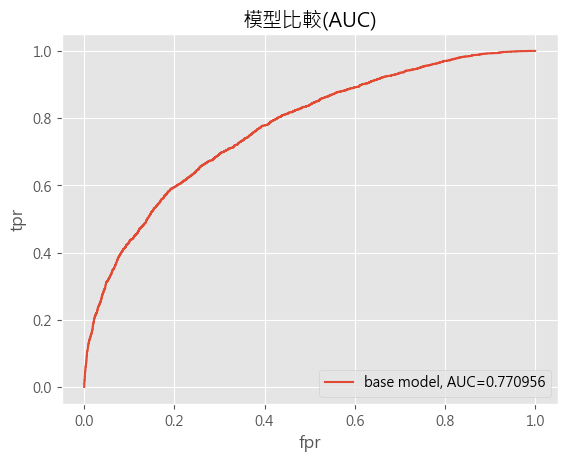

In [38]:
# plot ROC_AUC graph
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft Jhenghei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(0).clf()
plt.style.use("ggplot")

plt.plot(fpr,tpr,label="base model, AUC="+str(round(auc,6)))


plt.legend(loc="lower right")
plt.title("模型比較(AUC)")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.savefig("modelAUCs.png")

### 影響因子重要性

In [39]:
fcolumns=['性別', '教育', '神智', '年齡', '每月採尿平均', '實際保管長度', '違規次數', '獎勵次數', '犯次',
       '一年內次數', '二年內次數', '三年內次數', '四年內次數', '五年內次數', '首犯年齡']

In [40]:
factImportance = pd.DataFrame({'feature':fcolumns,
                              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

In [41]:
print(factImportance)

   feature  importance
5   實際保管長度    0.186442
8       犯次    0.157287
4   每月採尿平均    0.128834
2       神智    0.093226
1       教育    0.073561
9    一年內次數    0.071402
10   二年內次數    0.051014
11   三年內次數    0.048944
12   四年內次數    0.039784
7     獎勵次數    0.034595
13   五年內次數    0.033827
3       年齡    0.033376
14    首犯年齡    0.025994
0       性別    0.014340
6     違規次數    0.007374


### 計算混淆矩陣confusion matrix

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [43]:
cm #confusion matrix

array([[10539,   204],
       [ 1923,   415]], dtype=int64)